Here I run the entire program without adding any adhesion at all. 
I will then try to add adhesion to where the derivative of the contact forces was positive, as in the other scenario the fact that adding adhesion affected the contact forces was counter productive. 

In [2]:
import os
os.getcwd()
os.chdir('../')


In [3]:
os.getcwd()

'c:\\Users\\lschwitt\\flygym_adhesion-Laetitia'

In [4]:
#pip install -e ."[mujoco]

In [5]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs
from scipy.signal import medfilt


In [6]:

# Initialize simulation
run_time = 1
nmf = NeuroMechFlyMuJoCo(#render_mode='headless', #no graphic rendering: headless, rendering = 'saved'
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left', 'fps' :20},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs,
                         adhesion = False,
                         actuators_adhesion_gain = 8000,#at 20500 it flies away, at 21000 it stays
                         actuated_bodies='all')

bool_sum_of_allTarsi = False
window_size_medfilt = 501

[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="8000"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="8000"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="8000"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="8000"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="8000"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="8000"/>] actuators _adhesion


In [7]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
#with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
#    data = pickle.load(f)
with open(data_path / 'behavior' / 'tripod_engineered.pkl', 'rb') as f:
    data = pickle.load(f)
with open(data_path / 'behavior' / 'fly_floorwalking_5cycles_tripod.pkl', 'rb') as f:
    data = pickle.load(f)

In [8]:
print('Dict keys:', data.keys())
print('Length of time series:', len(data['joint_RFCoxa']))
print('Metadata:', data['meta'])
print(2000*0.0005) # 1 second! 

Dict keys: dict_keys(['meta', 'joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFCoxa_yaw', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMCoxa_yaw', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHCoxa_yaw', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFCoxa_yaw', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMCoxa_yaw', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHCoxa_yaw', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1'])
Length of time series: 6390
Metadata: {'timestep': 0.0001, 'source': 'Analyze_step_data.ipynb'}
1.0


In [9]:
run_time = len(data['joint_RFCoxa'])*nmf.timestep

num_steps_base = int(run_time / nmf.timestep)

In [10]:
# Interpolate 5x recording 
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))
measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [11]:
def plot_contact_forces(obs_list_simulation, bool_sum_of_allTarsi = False, window_size_medfilt = 1):
    # tarsi
    if bool_sum_of_allTarsi:
        text_path = 'SumAllTarsi'
        tarsi = np.array(['LFTarsus', 'LMTarsus', 'LHTarsus', 'RFTarsus', 'RMTarsus', 'RHTarsus'])
        contact_forces_simulation_noADH= [[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list_simulation]



    else:
        text_path = 'onlyTarsi5'
        tarsi = np.array(['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5'])
        contact_forces_simulation_noADH = [obs['contact_forces'][4::5] for obs in obs_list_simulation]

    assert window_size_medfilt % 2 == 1, "The window size for the median must be an odd integer"
    text_medfilt = ""
    if window_size_medfilt != 1:
        text_medfilt = "Median Filtered"
        

    # Extract the time and fly data for each simulation
    print(len(contact_forces_simulation_noADH))
    time_simulation = np.arange(len(contact_forces_simulation_noADH)) * nmf.timestep





    fig = plt.figure(figsize=(8, 6))

    # Plot data from the first simulation
    plt.plot(time_simulation, medfilt(contact_forces_simulation_noADH, (window_size_medfilt, 1)), linewidth=0.8)
    plt.ylabel('Contact Forces', fontsize=8)
    plt.tick_params(labelsize=8)
    plt.ylim(0, 500)
    if bool_sum_of_allTarsi:
        plt.title(f'Sum of all Tarsi Contact Forces {text_medfilt}', fontsize=9)
    else: 
        plt.title(f'Contact Forces on Tarsi 5 {text_medfilt}', fontsize=9)


    # Create a common legend outside the subplots
    fig.legend(labels=tarsi, loc='center', ncol=len(tarsi), bbox_to_anchor=(0.5, 0), fontsize=8)
    plt.tight_layout()

    fig = plt.gcf() 
    plt.show()
    plt.draw()

    #to save:
    save_path = Path('notebooks/PreRunAdhesionFigures',f'contact_force_{text_path}_{text_medfilt.replace(" ","")}.png')
    fig.savefig(save_path)

In [12]:
n_stabilisation_steps = 1000


# First run: Normal Gravity, no adhesion 

In [13]:
# Run simulation
nmf.physics.model.opt.gravity = (0,0,-9.81e5)
obs, info = nmf.reset() 
old_obs = obs
obs_list = [obs]
#obs_deriv_touch_sensor_Tarsi5 = []
adhesion_obs = []
for i in trange(num_steps + n_stabilisation_steps):
    #deriv_touch_sensor_Tarsi5 = (obs['contact_forces'][4::5]- old_obs['contact_forces'][4::5])/nmf.timestep
    #obs_deriv_touch_sensor_Tarsi5.append(deriv_touch_sensor_Tarsi5)
    """
    if i >= int(num_steps/2):
        #inverting gravity midsimulation
        nmf.physics.model.opt.gravity = (0,0,9.81e5)
    """
    if i <  n_stabilisation_steps:
        joint_pos = data_block[:, 0] #put back i
    else:
         joint_pos = data_block[:, i- n_stabilisation_steps] #put back i 
    #calculate adhesion
    action = {'joints': joint_pos, 'adhesion': np.zeros(6)} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

  0%|          | 0/7390 [00:00<?, ?it/s]

100%|██████████| 7390/7390 [00:12<00:00, 576.62it/s]


In [14]:
if bool_sum_of_allTarsi:
    contact_forces_simulation_noADH= [[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list]



else:
    contact_forces_simulation_noADH = [obs['contact_forces'][4::5] for obs in obs_list]
medfiltered_contact_forces = medfilt(contact_forces_simulation_noADH, (window_size_medfilt, 1))
print(np.shape(medfiltered_contact_forces))
derivative = np.gradient(medfiltered_contact_forces,nmf.timestep, axis=0)
print(np.shape(derivative))

adhesion_obs = np.where(np.array(derivative)> 0, 1, 0)
#adhesion_obs[:n_stabilisation_steps] = np.ones(6) 
print(adhesion_obs)

(7391, 6)
(7391, 6)
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [15]:
"""
windowsize = 501
medfiltered_derivative = medfilt(obs_deriv_touch_sensor_Tarsi5, (windowsize,1))

adhesion_obs = np.where(np.array(medfiltered_derivative)>= 0, 1, 0)
"""

'\nwindowsize = 501\nmedfiltered_derivative = medfilt(obs_deriv_touch_sensor_Tarsi5, (windowsize,1))\n\nadhesion_obs = np.where(np.array(medfiltered_derivative)>= 0, 1, 0)\n'

In [16]:
#adhesion_obs = np.where(np.array(obs_deriv_touch_sensor_Tarsi5) >= 0, 1, 0)

In [17]:
prerun_contact = []
for obs in obs_list:
    prerun_contact.append(obs['contact_forces'][4::5])  

In [18]:
#prerun_deriv = np.copy(obs_deriv_touch_sensor_Tarsi5)

In [19]:
adhesion_obs

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [20]:
# Create a list to hold the end effector data len(end_effector_data = 18;)
end_effector_data = [[] for _ in range(18)]

# Iterate through each observation in obs_list
for obs in obs_list:
    end_effectors = obs['end_effectors']

    # Iterate through each value in the end_effectors list and append to the corresponding sublist in end_effector_data
    for i, value in enumerate(end_effectors):
        end_effector_data[i].append(value)

end_effector_data = {'x_vals_end_effector_obs' : end_effector_data[::3], 'y_vals_end_effector_obs': end_effector_data[1::3] , 'z_vals_end_effector_obs': end_effector_data[2::3]}

Text(0, 0.5, 'z- Position end_effectors')

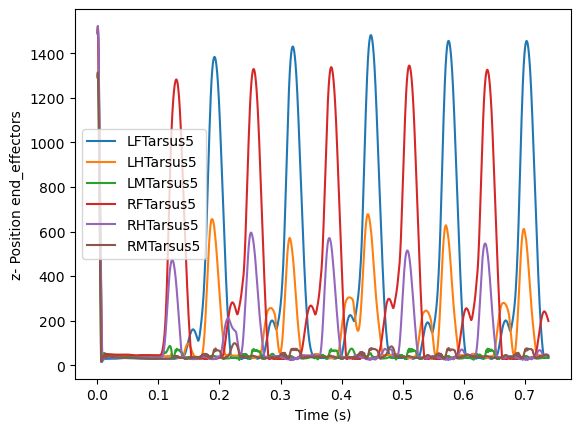

In [21]:
for i, end_effector in enumerate(end_effector_data['z_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('z- Position end_effectors')


Text(0, 0.5, 'y- Position end_effectors')

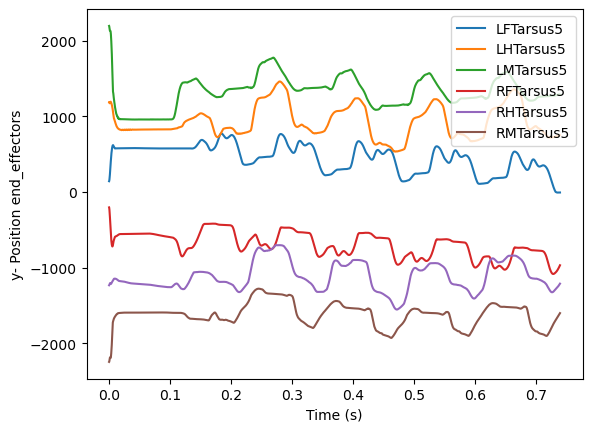

In [22]:
for i, end_effector in enumerate(end_effector_data['y_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('y- Position end_effectors')

Text(0, 0.5, 'x- Position end_effectors')

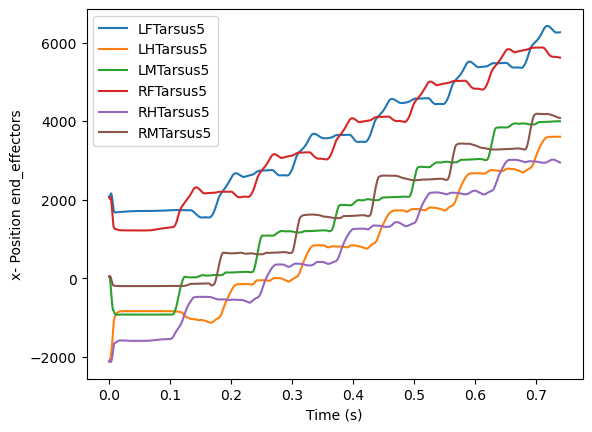

In [23]:
for i, end_effector in enumerate(end_effector_data['x_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('x- Position end_effectors')

In [24]:
nmf.actuated_adhesion_bodies[0]

'LFTarsus5'

In [25]:
np.arange(len(np.array(adhesion_obs)))

array([   0,    1,    2, ..., 7388, 7389, 7390])

Text(0, 0.5, 'adh_val')

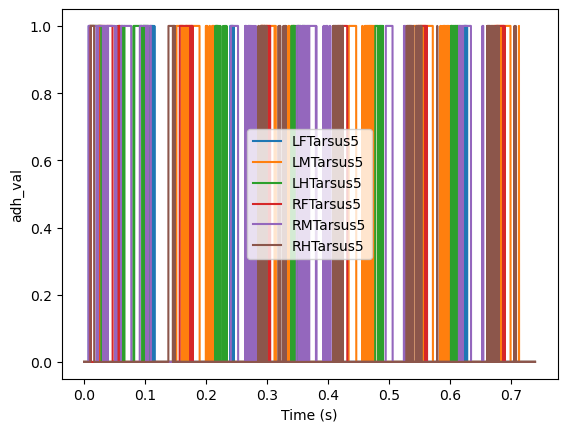

In [26]:
#calculating adhesion
nr_adhesion_bodies = 6
fig_adh = plt.figure(figsize = (7,6))
for i in range(6):
    ax1 = fig_adh.add_subplot(321 + i)
    ax1.plot(np.arange(len(adhesion_obs)) * nmf.timestep,np.array(adhesion_obs)[:, i], label=nmf.actuated_adhesion_bodies[i], linewidth = 0.8)
    ax1.set_xlabel('Time (s)', fontsize = 8)
    ax1.set_ylabel('adhesion [force]', fontsize = 8)
    ax1.legend(loc = "upper right", fontsize = 8)
    ax1.tick_params(labelsize = 8)
#plt.legend()
plt.tight_layout()
#plt.title("contact forces derivative: Tarsus5, normal gravity, no adhesion")



In [27]:
touch_sensor_names = []
for touch_sensors in nmf.touch_sensors:
    touch_sensor_names.append(touch_sensors.name)
print(touch_sensor_names)

['touch_LFTarsus1_collision', 'touch_LFTarsus2_collision', 'touch_LFTarsus3_collision', 'touch_LFTarsus4_collision', 'touch_LFTarsus5_collision', 'touch_LMTarsus1_collision', 'touch_LMTarsus2_collision', 'touch_LMTarsus3_collision', 'touch_LMTarsus4_collision', 'touch_LMTarsus5_collision', 'touch_LHTarsus1_collision', 'touch_LHTarsus2_collision', 'touch_LHTarsus3_collision', 'touch_LHTarsus4_collision', 'touch_LHTarsus5_collision', 'touch_RFTarsus1_collision', 'touch_RFTarsus2_collision', 'touch_RFTarsus3_collision', 'touch_RFTarsus4_collision', 'touch_RFTarsus5_collision', 'touch_RMTarsus1_collision', 'touch_RMTarsus2_collision', 'touch_RMTarsus3_collision', 'touch_RMTarsus4_collision', 'touch_RMTarsus5_collision', 'touch_RHTarsus1_collision', 'touch_RHTarsus2_collision', 'touch_RHTarsus3_collision', 'touch_RHTarsus4_collision', 'touch_RHTarsus5_collision']


In [28]:
touch_sensor_Tarsi5_names = touch_sensor_names[4::5]
print(touch_sensor_Tarsi5_names)

['touch_LFTarsus5_collision', 'touch_LMTarsus5_collision', 'touch_LHTarsus5_collision', 'touch_RFTarsus5_collision', 'touch_RMTarsus5_collision', 'touch_RHTarsus5_collision']


In [29]:
#np.shape(np.array(obs_deriv_touch_sensor_Tarsi5))

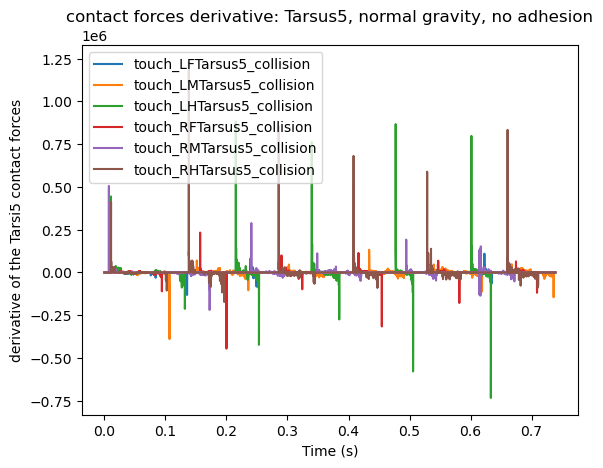

In [30]:
for i in range(nr_adhesion_bodies):
    plt.plot(np.arange(len(derivative)) * nmf.timestep,
        np.array(derivative)[:,i],
        label=touch_sensor_Tarsi5_names[i])
plt.legend()
plt.xlabel('Time (s)')
if bool_sum_of_allTarsi:
    plt.ylabel('derivative of the sum of all Tarsi contact forces')
    plt.title("contact forces derivative: Tarsus, normal gravity, no adhesion")
else:
    plt.ylabel('derivative of the Tarsi5 contact forces')
    plt.title("contact forces derivative: Tarsus5, normal gravity, no adhesion")

Text(0.5, 0.98, 'before timed adhesion and gravity normal')

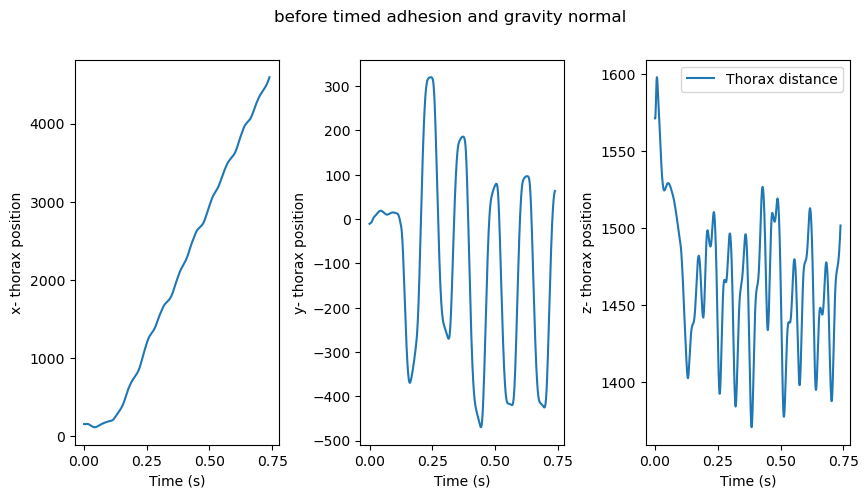

In [31]:
axis = ['x', 'y','z']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i, ax in enumerate(axes): 
    #fig.add_subplot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep, 130 + i, [obs['fly'][0][i] for obs in obs_list], label = "Thorax distance", xlabel = "time", ylabel = axis[i] + "thorax position" )
    ax.plot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep,[obs['fly'][0][i] for obs in obs_list], label = "Thorax distance")
    ax.set_ylabel(axis[i]+ "- thorax position")
    ax.set_xlabel('Time (s)')
plt.legend()
plt.subplots_adjust(wspace=0.4)

# plt.ylabel('x- Position end_effectors')
plt.suptitle('before timed adhesion and gravity normal')

Calculating the euclidian distance: 


In [32]:
distance_evolution = np.linalg.norm([obs['fly'][0] - obs_list[0]['fly'][0] for obs in obs_list], axis = 1)

Text(0.5, 0.5, 'final distance: 4439.241693222')

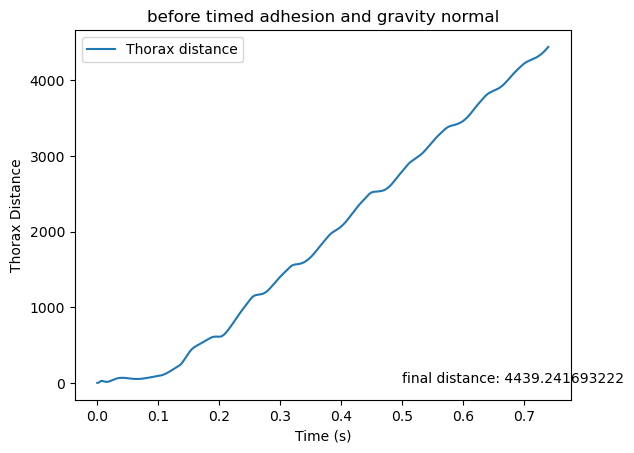

In [33]:
plt.plot(np.arange(np.shape(distance_evolution)[0]) * nmf.timestep,
    distance_evolution,
    label="Thorax distance")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Thorax Distance')
plt.title('before timed adhesion and gravity normal')
plt.text(0.5, 0.5, f"final distance: {distance_evolution[-1]}")

In [34]:
print(distance_evolution[-1])

4439.241693222


7391


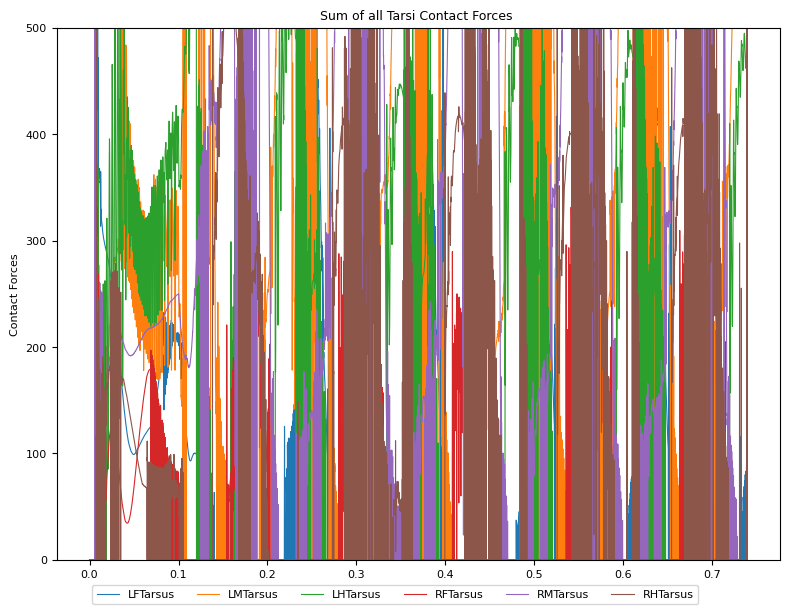

7391


<Figure size 640x480 with 0 Axes>

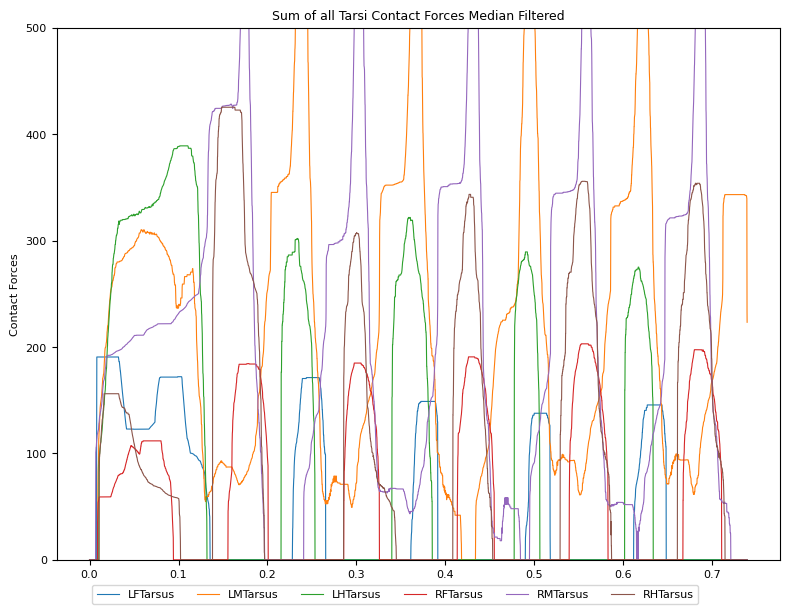

7391


<Figure size 640x480 with 0 Axes>

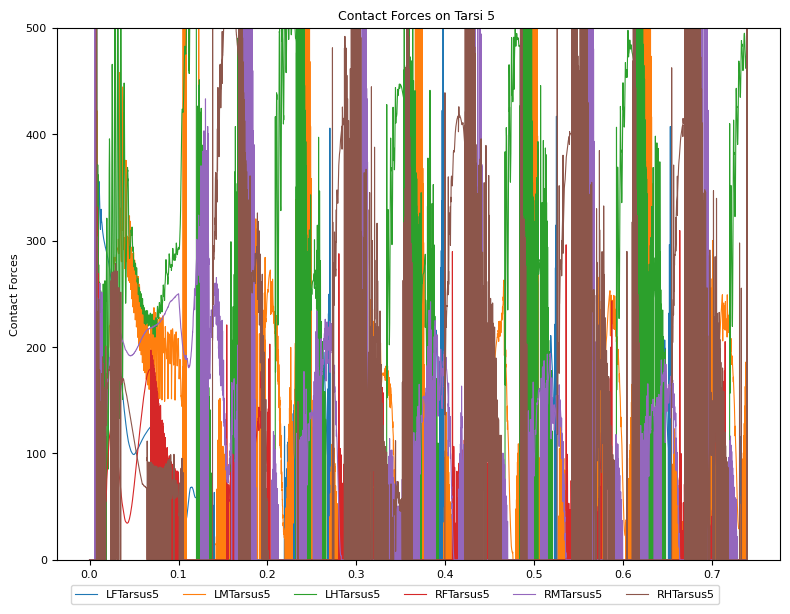

7391


<Figure size 640x480 with 0 Axes>

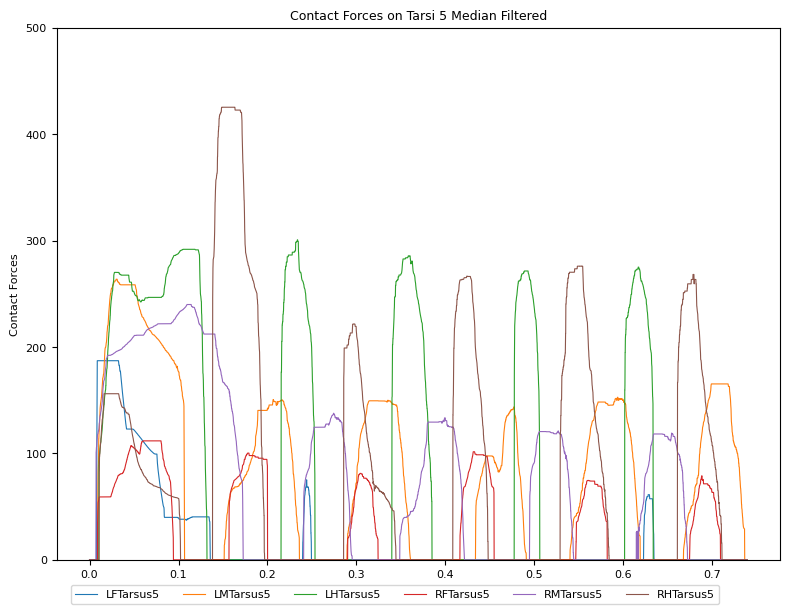

<Figure size 640x480 with 0 Axes>

In [35]:
plot_contact_forces(obs_list,bool_sum_of_allTarsi=True)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=True, window_size_medfilt= window_size_medfilt)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=False)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=False, window_size_medfilt=window_size_medfilt)

In [36]:
video_path = Path('PreRunAdhesion_Videos/video_noADH_modifs_MCoxa_45_MHscale1_5_Fscale0_75_left_view_NOADHESION.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\xd5\x82mdat\x0…

# 2nd run: Add Adhesion, Gravity still normal

In [37]:
np.shape(np.array(adhesion_obs))

(7391, 6)

In [38]:
# Run simulation
obs, info = nmf.reset() 
old_obs = obs
obs_list = [obs]
#obs_deriv_touch_sensor_Tarsi5 = []
for i in trange(num_steps + n_stabilisation_steps):
    #deriv_touch_sensor_Tarsi5 = (obs['contact_forces'][4::5]- old_obs['contact_forces'][4::5])/nmf.timestep
    #obs_deriv_touch_sensor_Tarsi5.append(deriv_touch_sensor_Tarsi5)
    if i < n_stabilisation_steps:
        joint_pos = data_block[:, 0] 
        action = {'joints': joint_pos, 'adhesion': np.array(adhesion_obs)[i,:]} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}

    else:
        joint_pos = data_block[:, i-n_stabilisation_steps] #put back i 
        #calculate adhesion
        action = {'joints': joint_pos, 'adhesion': np.array(adhesion_obs)[i,:]} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

100%|██████████| 7390/7390 [00:14<00:00, 504.47it/s]


In [39]:
# Create a list to hold the end effector data len(end_effector_data = 18;)
end_effector_data = [[] for _ in range(18)]

# Iterate through each observation in obs_list
for obs in obs_list:
    end_effectors = obs['end_effectors']

    # Iterate through each value in the end_effectors list and append to the corresponding sublist in end_effector_data
    for i, value in enumerate(end_effectors):
        end_effector_data[i].append(value)

end_effector_data = {'x_vals_end_effector_obs' : end_effector_data[::3], 'y_vals_end_effector_obs': end_effector_data[1::3] , 'z_vals_end_effector_obs': end_effector_data[2::3]}

In [40]:
afterrun_contact = []
for obs in obs_list:
    afterrun_contact.append(obs['contact_forces'][4::5])  

In [41]:
diff = np.array(prerun_contact) - np.array(afterrun_contact)

In [42]:
diff

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       ...,
       [ 71.49096814, 105.97689528, 488.52703532,   0.        ,
          0.        ,   0.        ],
       [ 71.88558721,   0.        , 488.71443423,   0.        ,
          0.        ,   0.        ],
       [ 72.55225034,  74.49992634, 488.12691965,   0.        ,
          0.        , 627.21048439]])

Text(0, 0.5, 'z- Position end_effectors')

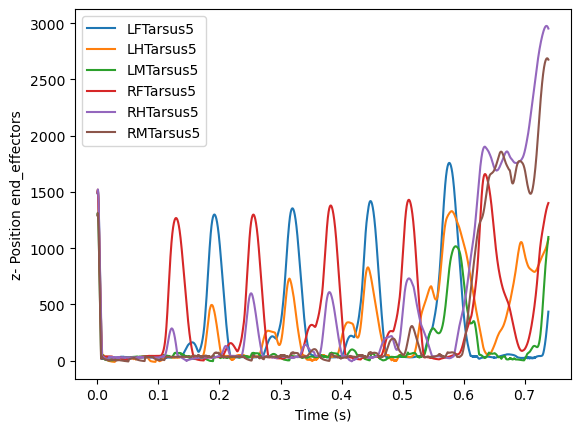

In [43]:
for i, end_effector in enumerate(end_effector_data['z_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('z- Position end_effectors')


Text(0, 0.5, 'x- Position end_effectors')

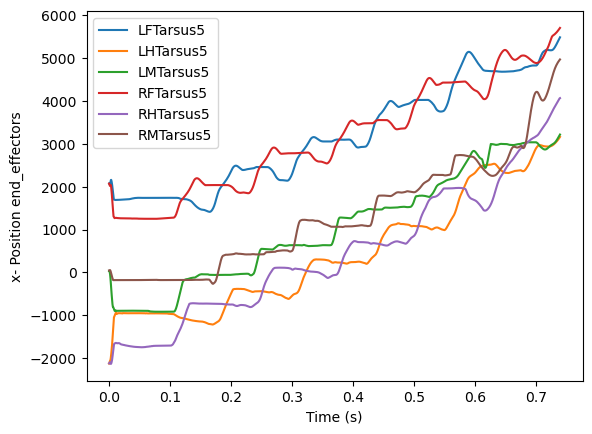

In [44]:
for i, end_effector in enumerate(end_effector_data['x_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('x- Position end_effectors')

Text(0.5, 0.98, 'after timed adhesion and gravity normal')

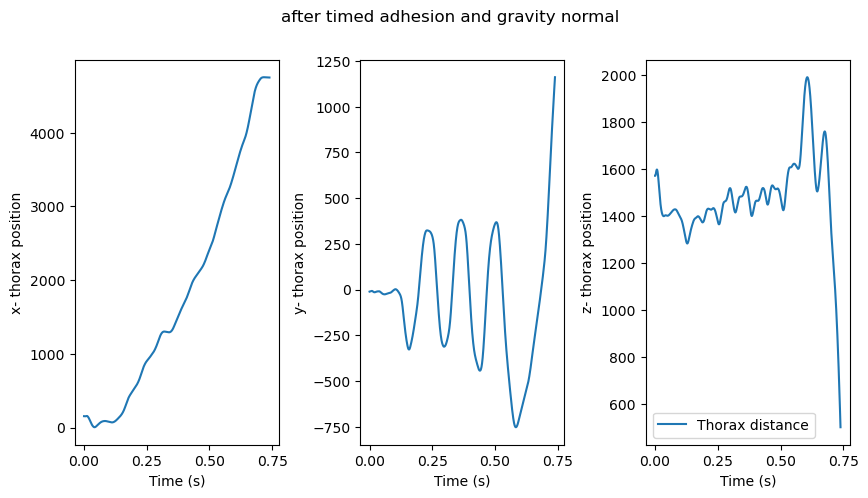

In [45]:
axis = ['x', 'y','z']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i, ax in enumerate(axes): 
    #fig.add_subplot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep, 130 + i, [obs['fly'][0][i] for obs in obs_list], label = "Thorax distance", xlabel = "time", ylabel = axis[i] + "thorax position" )
    ax.plot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep,[obs['fly'][0][i] for obs in obs_list], label = "Thorax distance")
    ax.set_ylabel(axis[i]+ "- thorax position")
    ax.set_xlabel('Time (s)')
plt.legend()
plt.subplots_adjust(wspace=0.4)

# plt.ylabel('x- Position end_effectors')
plt.suptitle('after timed adhesion and gravity normal')

Calculating the euclidian distance: 


In [46]:
distance_evolution = np.linalg.norm([obs['fly'][0] - obs_list[0]['fly'][0] for obs in obs_list], axis = 1)

Text(0.5, 0.5, 'final distance: 4858.515306286937')

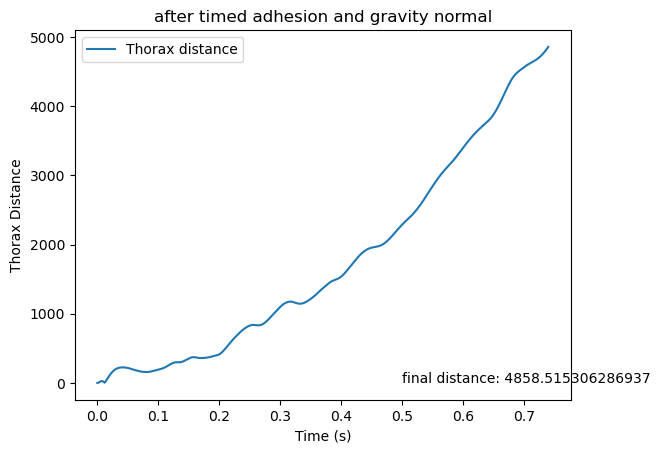

In [47]:
plt.plot(np.arange(np.shape(distance_evolution)[0]) * nmf.timestep,
    distance_evolution,
    label="Thorax distance")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Thorax Distance')
plt.title('after timed adhesion and gravity normal')
plt.text(0.5, 0.5, f"final distance: {distance_evolution[-1]}")

7391


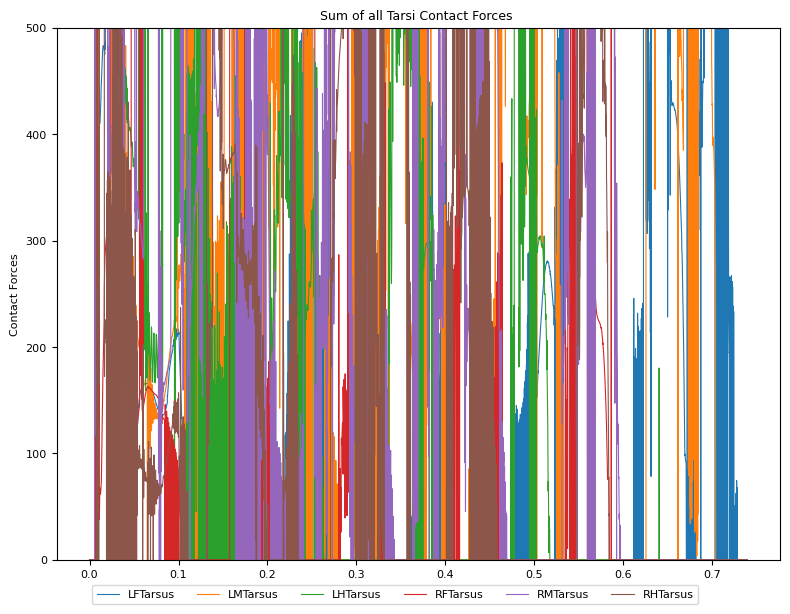

7391


<Figure size 640x480 with 0 Axes>

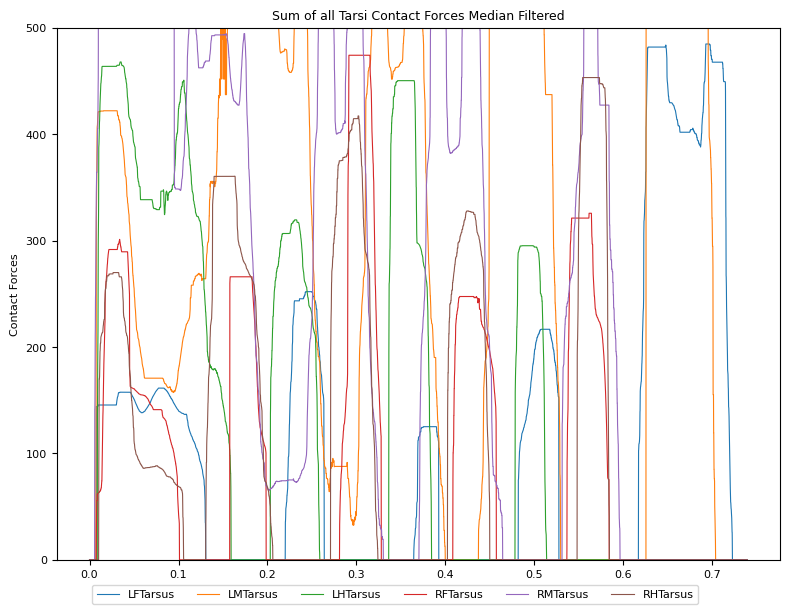

7391


<Figure size 640x480 with 0 Axes>

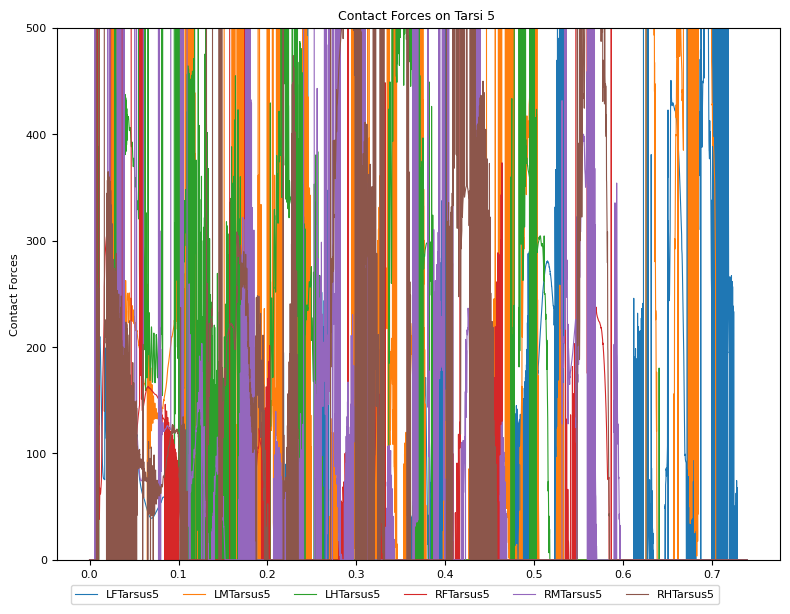

7391


<Figure size 640x480 with 0 Axes>

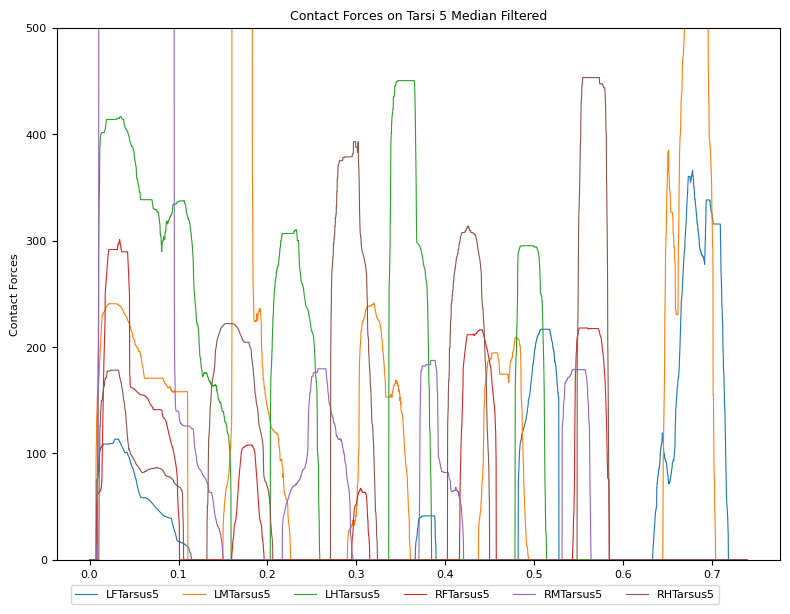

<Figure size 640x480 with 0 Axes>

In [48]:
plot_contact_forces(obs_list,bool_sum_of_allTarsi=True)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=True, window_size_medfilt= window_size_medfilt)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=False)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=False, window_size_medfilt=window_size_medfilt)

In [49]:
video_path = Path('PreRunAdhesion_Videos/video_noADH_modifs_MCoxa_45_MHscale1_5_Fscale0_75_left_view_ADHESION.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x06\\\x1fmdat\x00\…

# 3nd run: Add Adhesion, Gravity inverted 

In [50]:
#so that the fly doesnt directly fly away.
adhesion_obs = np.where(np.array(derivative)>= 0, 1, 0)
adhesion_obs[:n_stabilisation_steps] = np.ones(6) 


In [51]:
# Run simulation
obs, info = nmf.reset() 
nmf.physics.model.opt.gravity = (0,0,9.81e5)
adhesion_gain_multiply = 20
old_obs = obs
obs_list = [obs]
#obs_deriv_touch_sensor_Tarsi5 = []
for i in trange(num_steps + n_stabilisation_steps):
    #deriv_touch_sensor_Tarsi5 = (obs['contact_forces'][4::5]- old_obs['contact_forces'][4::5])/nmf.timestep
    #obs_deriv_touch_sensor_Tarsi5.append(deriv_touch_sensor_Tarsi5)
    """
    if i >= int(num_steps/2):
        #inverting gravity midsimulation
        nmf.physics.model.opt.gravity = (0,0,9.81e5)
    """
    if i < n_stabilisation_steps:
        joint_pos = data_block[:, 0] 
        action = {'joints': joint_pos, 'adhesion': adhesion_gain_multiply*np.array(adhesion_obs)[0,:]}
    else: 

        joint_pos = data_block[:, i-n_stabilisation_steps] #put back i 
        #calculate adhesion
        action = {'joints': joint_pos, 'adhesion': adhesion_gain_multiply*np.array(adhesion_obs)[i,:]} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

100%|██████████| 7390/7390 [00:59<00:00, 123.98it/s]


In [52]:
# Create a list to hold the end effector data len(end_effector_data = 18;)
end_effector_data = [[] for _ in range(18)]

# Iterate through each observation in obs_list
for obs in obs_list:
    end_effectors = obs['end_effectors']

    # Iterate through each value in the end_effectors list and append to the corresponding sublist in end_effector_data
    for i, value in enumerate(end_effectors):
        end_effector_data[i].append(value)

end_effector_data = {'x_vals_end_effector_obs' : end_effector_data[::3], 'y_vals_end_effector_obs': end_effector_data[1::3] , 'z_vals_end_effector_obs': end_effector_data[2::3]}

In [53]:
afterrun_inv_grav_contact = []
for obs in obs_list:
    afterrun_inv_grav_contact.append(obs['contact_forces'][4::5])  

In [54]:
diff = np.array(prerun_contact) - np.array(afterrun_inv_grav_contact)

Text(0.5, 1.0, 'after timed adhesion and gravity inverted')

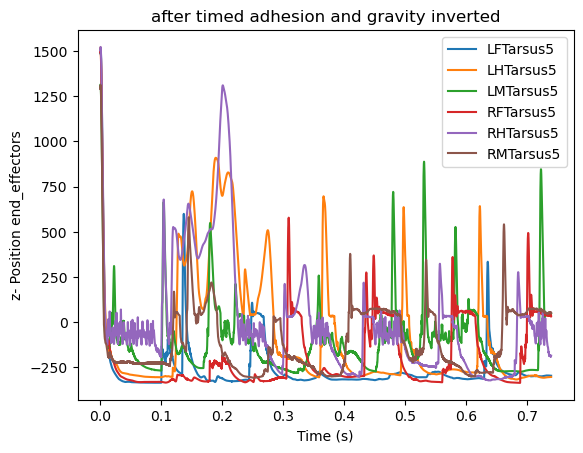

In [55]:
for i, end_effector in enumerate(end_effector_data['z_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('z- Position end_effectors')
plt.title('after timed adhesion and gravity inverted')

Text(0.5, 1.0, 'after timed adhesion and gravity inverted')

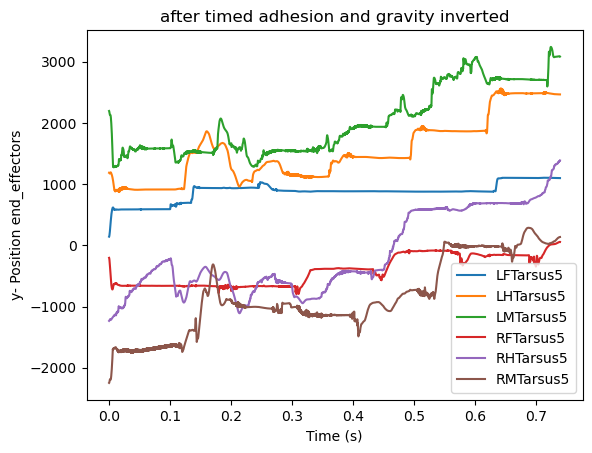

In [56]:
for i, end_effector in enumerate(end_effector_data['y_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('y- Position end_effectors')
plt.title('after timed adhesion and gravity inverted')

Text(0.5, 1.0, 'after timed adhesion and gravity inverted')

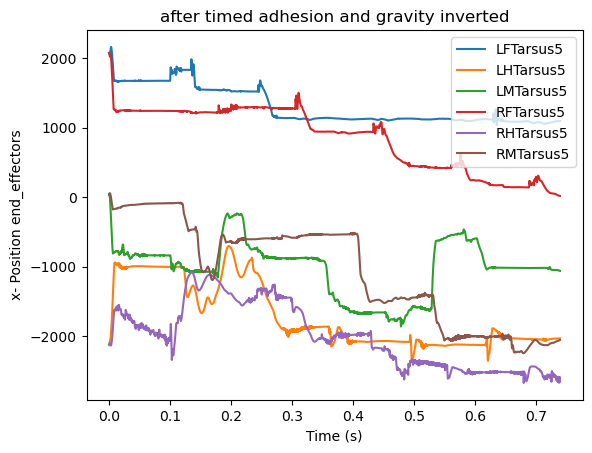

In [57]:
for i, end_effector in enumerate(end_effector_data['x_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('x- Position end_effectors')
plt.title('after timed adhesion and gravity inverted')


# Thorax displacement 

Text(0.5, 0.98, 'after timed adhesion and gravity inverted')

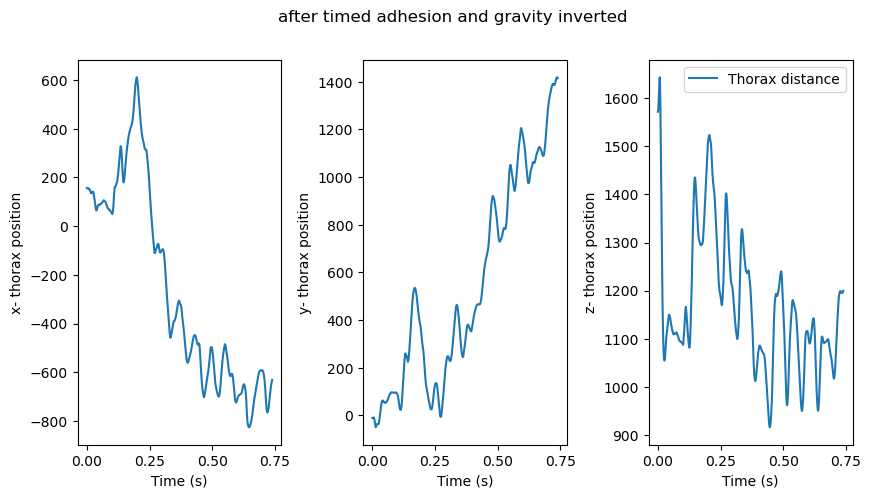

In [58]:
axis = ['x', 'y','z']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i, ax in enumerate(axes): 
    #fig.add_subplot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep, 130 + i, [obs['fly'][0][i] for obs in obs_list], label = "Thorax distance", xlabel = "time", ylabel = axis[i] + "thorax position" )
    ax.plot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep,[obs['fly'][0][i] for obs in obs_list], label = "Thorax distance")
    ax.set_ylabel(axis[i]+ "- thorax position")
    ax.set_xlabel('Time (s)')
plt.legend()
plt.subplots_adjust(wspace=0.4)

# plt.ylabel('x- Position end_effectors')
plt.suptitle('after timed adhesion and gravity inverted')

Calculating the euclidian distance: 


In [59]:
obs_list[0]['fly']

array([[ 1.56515377e+02, -1.06738401e+01,  1.57142617e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.57063908e+00,  2.07869279e-04,  9.09672773e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

Text(0.5, 0.5, 'final distance: -787.4185127948008')

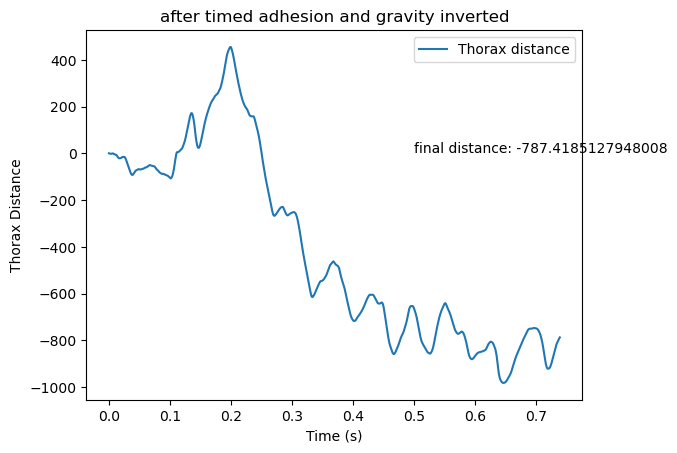

In [60]:
distance_evolution = np.linalg.norm([obs['fly'][0] - obs_list[0]['fly'][0] for obs in obs_list], axis = 1)
x_distance_evolution = [obs['fly'][0][0] - obs_list[0]['fly'][0][0] for obs in obs_list]

plt.plot(np.arange(len(x_distance_evolution)) * nmf.timestep,
    x_distance_evolution,
    label="Thorax distance")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Thorax Distance')
plt.title('after timed adhesion and gravity inverted')
plt.text(0.5, 0.5, f"final distance: {x_distance_evolution[-1]}")

Text(0.5, 0.5, 'final distance: 1670.5237603425974')

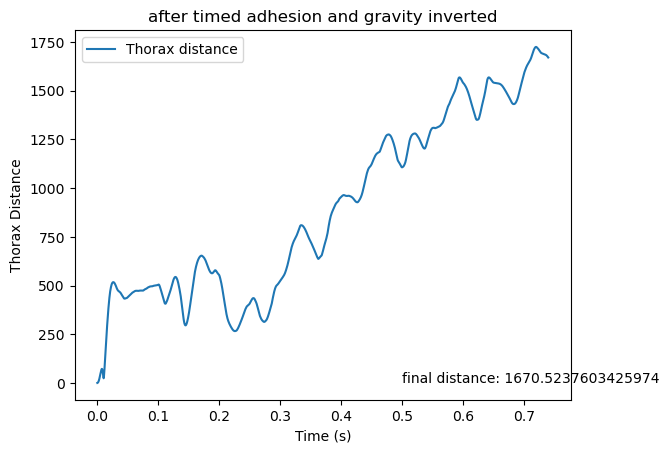

In [61]:
plt.plot(np.arange(np.shape(distance_evolution)[0]) * nmf.timestep,
    distance_evolution,
    label="Thorax distance")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Thorax Distance')
plt.title('after timed adhesion and gravity inverted')
plt.text(0.5, 0.5, f"final distance: {distance_evolution[-1]}")

In [62]:
print(distance_evolution[-1])

1670.5237603425974


In [63]:
video_path = Path('PreRunAdhesion_Videos/video_noADH_modifs_MCoxa_45_MHscale1_5_Fscale0_75_left_view_ADHESION_INVGrav.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05Mamdat\x00\x00\…

7391


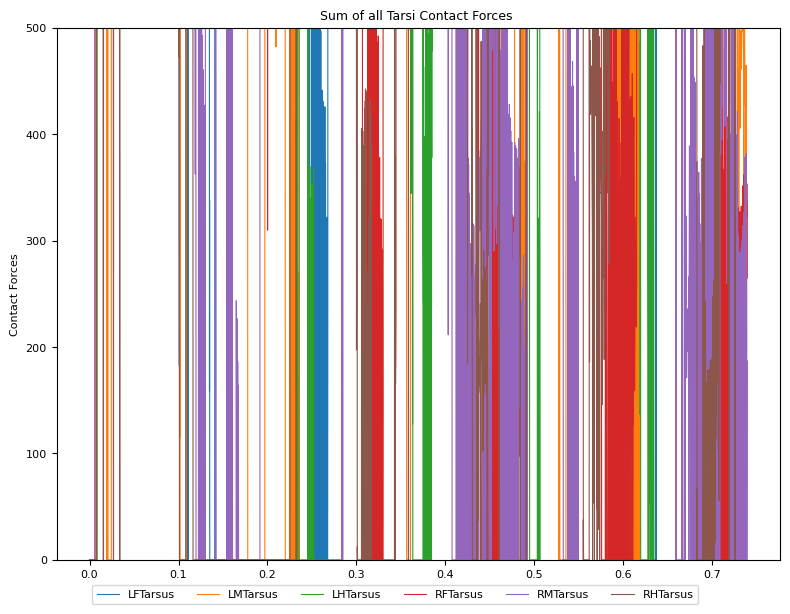

7391


<Figure size 640x480 with 0 Axes>

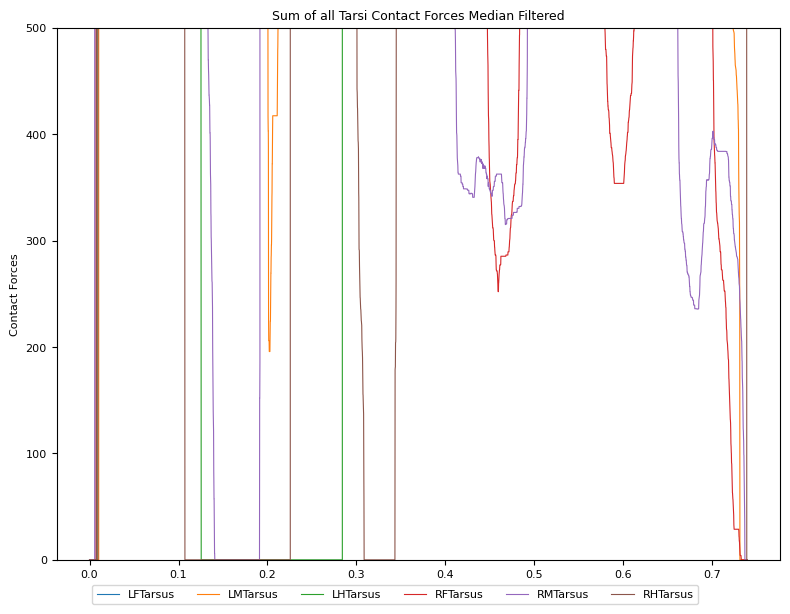

7391


<Figure size 640x480 with 0 Axes>

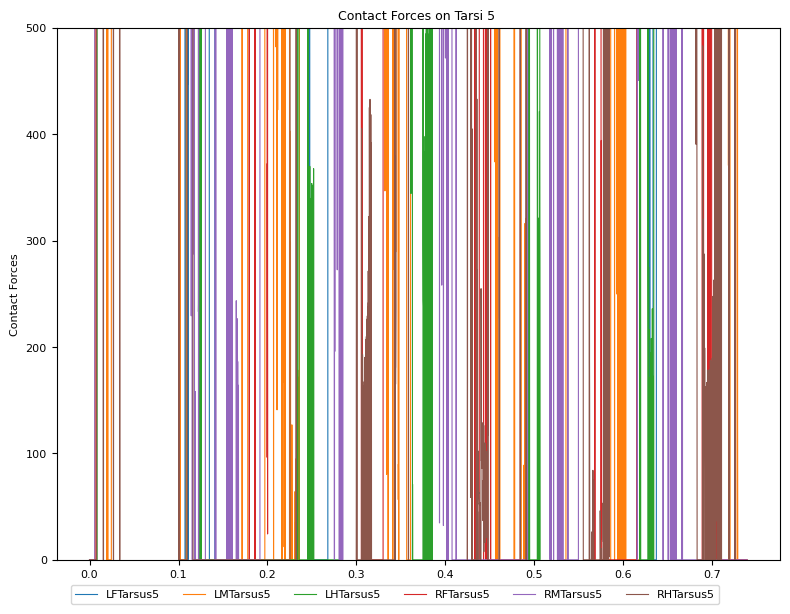

7391


<Figure size 640x480 with 0 Axes>

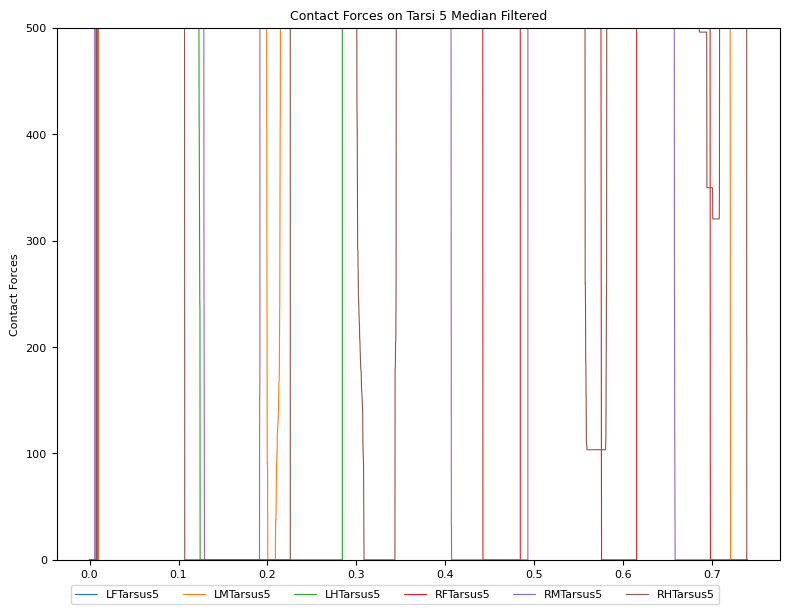

<Figure size 640x480 with 0 Axes>

In [64]:
plot_contact_forces(obs_list,bool_sum_of_allTarsi=True)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=True, window_size_medfilt= window_size_medfilt)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=False)
plot_contact_forces(obs_list,bool_sum_of_allTarsi=False, window_size_medfilt=window_size_medfilt)

# Dynamic 

In [65]:
#so that the fly doesnt directly fly away.
adhesion_obs = np.where(np.array(derivative)>= 0, 1, 0)
adhesion_obs[:n_stabilisation_steps] = np.ones(6) 


In [66]:
# Run simulation
window_size_medfilt =1001
obs, info = nmf.reset() 
nmf.physics.model.opt.gravity = (0,0,9.81e5)
adhesion_gain_multiply = 8
old_obs = obs
obs_list = [obs]
deriv_list = []
adhesion_list = []
for i in trange(num_steps + n_stabilisation_steps):
    if bool_sum_of_allTarsi:
        medold = np.median([[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list[-window_size_medfilt-1:-2]], axis = 0)
        mednew = np.median([[np.sum(obs['contact_forces'][i*5:i*5 + 5]) for i in np.arange(6)] for obs in obs_list[-window_size_medfilt:-1]], axis = 0)
        derivative = (mednew-medold) / nmf.timestep
        #print(np.shape(derivative))
    else:
        medold = np.median([obs['contact_forces'][4::5] for obs in obs_list[-window_size_medfilt-1:-2]], axis = 0)
        mednew = np.median([obs['contact_forces'][4::5] for obs in obs_list[-window_size_medfilt:-1]], axis = 0)
        derivative = (mednew-medold) / nmf.timestep
        #print(np.shape(derivative))
        #so that the fly doesnt directly fly away.
    if i == 0:
        derivative = np.zeros(6)
    deriv_list.append(derivative)
    adhesion = np.where(np.array(derivative)>= 0, 1, 0)
        
    #deriv_touch_sensor_Tarsi5 = (obs['contact_forces'][4::5]- old_obs['contact_forces'][4::5])/nmf.timestep
    #obs_deriv_touch_sensor_Tarsi5.append(deriv_touch_sensor_Tarsi5)
    """
    if i >= int(num_steps/2):
        #inverting gravity midsimulation
        nmf.physics.model.opt.gravity = (0,0,9.81e5)
    """
    if i < n_stabilisation_steps:
        joint_pos = data_block[:, 0] 
        adhesion = np.ones(6) 
        action = {'joints': joint_pos, 'adhesion': adhesion_gain_multiply*adhesion}
    else: 

        joint_pos = data_block[:, i-n_stabilisation_steps] #put back i 
        #calculate adhesion
        action = {'joints': joint_pos, 'adhesion': adhesion_gain_multiply*adhesion} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}
    #print(derivative)
    adhesion_list.append(adhesion)
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

  0%|          | 0/7390 [00:00<?, ?it/s]c:\Users\lschwitt\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\lschwitt\AppData\Local\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 7390/7390 [00:46<00:00, 160.44it/s]


In [67]:
np.shape(deriv_list)



(7390, 6)

In [68]:
deriv_list[0][0]

0.0

In [69]:
np.array(deriv_list)[:, 0]

array([ 0., nan,  0., ...,  0.,  0.,  0.])

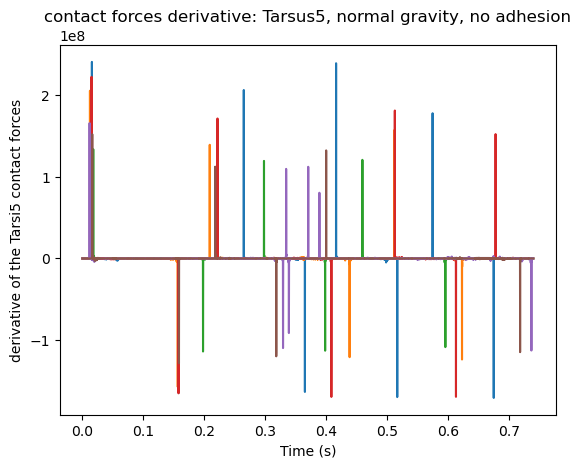

In [70]:
for i in range(6):
    plt.plot(np.arange(len(deriv_list)) * nmf.timestep,
        np.array(deriv_list)[:, i])#,
        #label=touch_sensor_Tarsi5_names[i])
#plt.legend()
plt.xlabel('Time (s)')
if bool_sum_of_allTarsi:
    plt.ylabel('derivative of the sum of all Tarsi contact forces')
    plt.title("contact forces derivative: Tarsus, normal gravity, no adhesion")
else:
    plt.ylabel('derivative of the Tarsi5 contact forces')
    plt.title("contact forces derivative: Tarsus5, normal gravity, no adhesion")

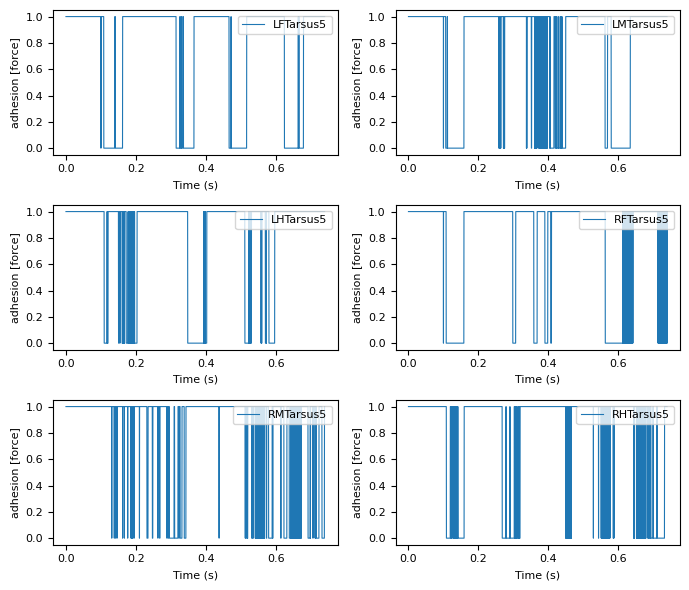

In [93]:
fig_adh = plt.figure(figsize = (7,6))
for i in range(6):
    ax1 = fig_adh.add_subplot(321 + i)
    ax1.plot(np.arange(len(adhesion_list)) * nmf.timestep,np.array(adhesion_list)[:, i], label=nmf.actuated_adhesion_bodies[i], linewidth = 0.8)
    ax1.set_xlabel('Time (s)', fontsize = 8)
    ax1.set_ylabel('adhesion [force]', fontsize = 8)
    ax1.legend(loc = "upper right", fontsize = 8)
    ax1.tick_params(labelsize = 8)
#plt.legend()
plt.tight_layout()
#plt.title("contact forces derivative: Tarsus5, normal gravity, no adhesion")

In [ ]:
video_path = Path('PreRunAdhesion_Videos/video_noADH_modifs_MCoxa_45_MHscale1_5_Fscale0_75_left_view_DYNADHESION.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x06`\xfemdat\x00\x…

In [ ]:
all_adhesion_bodies = [
    #name of all adhesion actuators
    f'{side}{pos}{dof}' #TO DO: potentiall its just this for the bodies : f'{side}{pos}{dof}' 
    for side in 'LR'
    for pos in 'FMH'
    #for dof in ['Tarsus1', 'Tarsus2', 'Tarsus3', 'Tarsus4', 'Tarsus5']
    for dof in ['Tarsus5']
]

In [ ]:
all_adhesion_bodies

['LFTarsus5', 'LMTarsus5', 'LHTarsus5', 'RFTarsus5', 'RMTarsus5', 'RHTarsus5']